## This notebook will explore a dataset for climbers around the world. The dataset is a processed version of an original 8a.nu site dataset of which was not available when I first found this.

##  Contents - info given by dataset provider:
### Grading table: grades_conversion_table.csv

This table gives you the conversion from numbered to french grading.<br>

### Routes table: routes_rated.csv
name_id -> the route id
I cleaned the ascensions table and gave some shape so you dont have to worry about problems like having 10 different names for the same route or crag.

grade_mean -> mean of all ascensions
I changed a little bit the ascension grading: if someone stated that a route was hard 7a, then I put a 7a/+, same with soft grading. After that I calculated the median for all the grading of each route (more robust with outlayers)

rating_total -> I did this calculation based on 3 features and taking the first component of the PCA:

    comment sentiment
    rating
    recomendations

tall_recommend_sum -> For each route I am adding up the following:

    if the person is tall and consider route easy +1
    if the person is tall and consider route hard -1
    if the person is short and consider route easy -1
    if the person is short and consider route hard +1
    (considering tall > 180cm, short < 170cm)

cluster -> I clustered the routes in 9 different clusters that can be more or less identified like:<br>
0 - Soft routes<br>
1 - Routes for some reason preferred by women<br>
2 - Famouse routes<br>
3 - Very hard routes<br>
4 - Very repeated routes<br>
5 - Chipped routes, with soft rate<br>
6 - Traditiona, not chipped routes<br>
7 - Easy to On-sight routes, not very repeated<br>
8 - Very famouse routes but not so repeated and not so traditional<br>

### Climbers table: climber_df.csv
date_first -> date of the first ascension<br>
date_last -> date of the last ascension<br>
grades_first -> grade of the first ascension<br>
grades_last -> grade of the last ascension<br>
years_cl -> years climbing<br>
grades_count -> number of routes done by climber<br>
year_first -> year of the first ascension<br>
year_last -> year of the last ascension<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

In [2]:
climbers = pd.read_csv('./data/climber_df.csv')
grade_conversion = pd.read_csv('./data/grades_conversion_table.csv', index_col=0)
routes_rated = pd.read_csv('./data/routes_rated.csv', index_col=0)

In [145]:
climbers.head()

,user_id,country,sex,height,weight,age,years_cl,date_first,date_last,grades_count,grades_first,grades_last,grades_max,grades_mean,year_first,year_last
0,1,SWE,0,177,73,41.0,21,1999-02-06 23:00:00,2001-07-31 22:00:00,84,36,55,62,46.750000,1999,2001
1,3,SWE,0,180,78,44.0,22,1999-03-31 22:00:00,2000-07-19 22:00:00,12,53,51,59,52.833333,1999,2000
2,4,SWE,1,165,58,33.0,16,2004-06-30 22:00:00,2009-05-26 22:00:00,119,53,49,64,53.890756,2004,2009
3,10,SWE,0,167,63,52.0,25,2000-01-14 23:00:00,2017-06-01 22:00:00,298,53,49,63,49.406040,2000,2017
4,16,NOR,0,177,68,44.0,21,1998-02-27 23:00:00,2010-05-13 22:00:00,5,53,49,53,51.400000,1998,2010


In [146]:
climbers['grades_first'].min()

28

In [147]:
grade_conversion[grade_conversion['grade_id'] > 28].head()

,grade_id,grade_fra
29,29,5
30,30,5a
31,31,5a+
32,32,5b
33,33,5b+


In [148]:
routes_rated.head()

,name_id,country,crag,sector,name,tall_recommend_sum,grade_mean,cluster,rating_tot
0,0,and,montserrat,prohibitivo,diagonal de la x,-1,49.250000,3,-0.045211
1,1,and,montserrat,prohibitivo,mehir,-1,49.000000,2,0.116464
2,2,and,montserrat,prohibitivo,pas de la discordia,0,49.000000,2,0.178722
3,3,and,tartareu,bombo suis,tenedor libre,0,44.333333,3,0.158449
4,4,arg,bandurrias,rincon,tendinitis,1,48.500000,0,0.075797


In [149]:
routes_rated['grade_mean'].min()

29.0

There's 3 french grades without representation. From looking into this dataset it seems the minimum grade is 28 so this part of the conversion won't be used anyway so i'll drop them from the dataset

In [3]:
grade_conversion.drop(grade_conversion[grade_conversion['grade_fra'] == '-'].index, inplace=True)
grade_conversion.reset_index(drop=True, inplace=True)

<Axes: xlabel='grade_id', ylabel='grade_fra'>

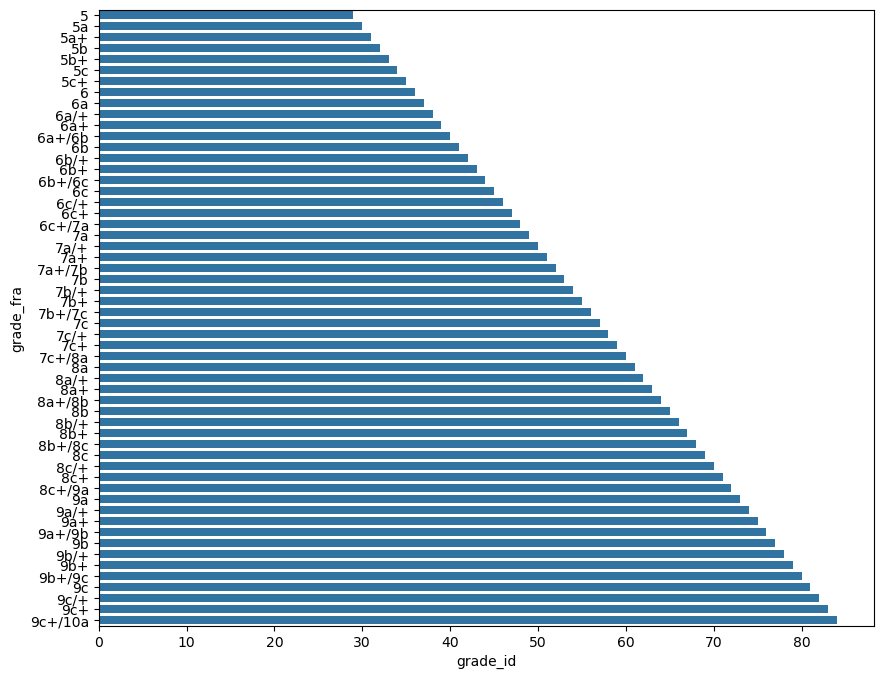

In [27]:
plt.figure(figsize=(10, 8))
plt.tight_layout()
sns.barplot(grade_conversion[grade_conversion['grade_id'] > 28], x='grade_id', y='grade_fra')

In [151]:
routes_rated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55858 entries, 0 to 55857
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name_id             55858 non-null  int64  
 1   country             55858 non-null  object 
 2   crag                55858 non-null  object 
 3   sector              55858 non-null  object 
 4   name                55858 non-null  object 
 5   tall_recommend_sum  55858 non-null  int64  
 6   grade_mean          55858 non-null  float64
 7   cluster             55858 non-null  int64  
 8   rating_tot          55858 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 4.3+ MB


In [152]:
climbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10927 entries, 0 to 10926
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10927 non-null  int64  
 1   country       10927 non-null  object 
 2   sex           10927 non-null  int64  
 3   height        10927 non-null  int64  
 4   weight        10927 non-null  int64  
 5   age           10927 non-null  float64
 6   years_cl      10927 non-null  int64  
 7   date_first    10927 non-null  object 
 8   date_last     10927 non-null  object 
 9   grades_count  10927 non-null  int64  
 10  grades_first  10927 non-null  int64  
 11  grades_last   10927 non-null  int64  
 12  grades_max    10927 non-null  int64  
 13  grades_mean   10927 non-null  float64
 14  year_first    10927 non-null  int64  
 15  year_last     10927 non-null  int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 1.3+ MB


No null/NaN data, as expected from this dataset as it's processed based off an original. Good to see nothing missed there

In [4]:
cluster_medians = routes_rated.groupby('cluster')['grade_mean'].mean().reset_index()

cluster_medians_sorted = cluster_medians.sort_values(by='grade_mean')

sorted_clusters = cluster_medians_sorted['cluster'].tolist()

In [5]:
cluster_descriptions = {
    0: 'Soft routes',
    1: 'Routes preferred by women',
    2: 'Famous routes',
    3: 'Very hard routes',
    4: 'Very repeated routes',
    5: 'Chipped routes, with soft rate',
    6: 'Traditional, not chipped routes',
    7: 'Easy to On-sight routes, not very repeated',
    8: 'Very famous routes but not so repeated and not so traditional'
}

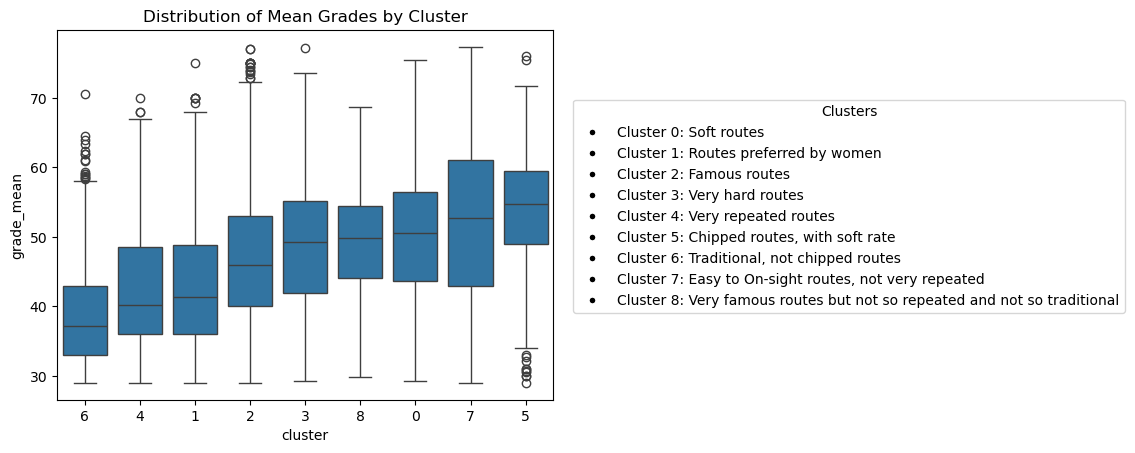

In [7]:
sns.boxplot(x='cluster', y='grade_mean', data=routes_rated, order=sorted_clusters)
plt.title('Distribution of Mean Grades by Cluster')
legend_labels = [f'Cluster {num}: {desc}' for num, desc in cluster_descriptions.items()]

legend_handles = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {num}: {desc}',
                         markersize=5, markerfacecolor='black') for num, desc in cluster_descriptions.items()]
plt.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=5, title="Clusters")
plt.show()

In [9]:
cluster_sample_size = routes_rated.groupby('cluster')['name_id'].count()
cluster_sample_size

cluster
0     6561
1     7048
2    30500
3     5601
4     1333
5      506
6     1176
7     1354
8     1779
Name: name_id, dtype: int64

- This looks like 5 should be the hardest average routes.
    - However this dataset is already biased towards more dedicated and usually better climbers, which means there'll be more data on the higher grade climbs
    - Given that each of the clusters seems to have almost the full range of grades each and the different sample sizes I don't think we can conclusively assume anything with this.

<Axes: xlabel='grade_mean', ylabel='Count'>

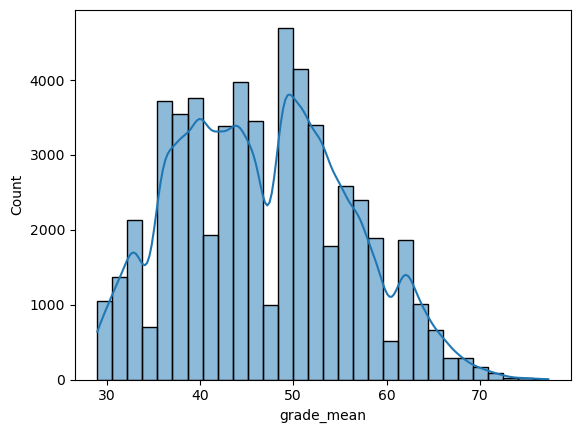

In [10]:
sns.histplot(routes_rated['grade_mean'],kde=True, bins=30)

- The range of the grades is slightly right skewed which backs up the idea of this dataset being biased towards higher grade climbs.
- It seems to be a multimodal distribution but that is likely due to the grading systems being so varied for different countries so when converted we may not see many of the grades actually showing up.

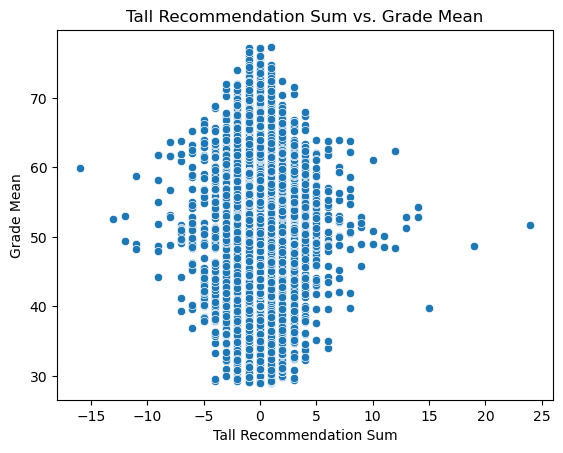

In [11]:
sns.scatterplot(x='tall_recommend_sum', y='grade_mean', data=routes_rated)
plt.title('Tall Recommendation Sum vs. Grade Mean')
plt.xlabel('Tall Recommendation Sum')
plt.ylabel('Grade Mean')
plt.show()

- From what we know of the distribution of grades, it doesn't seem like there's any obvious correlation between the grade of a climb and it's difficulty depending on the height of the climber.
    - Perhaps if we look at these recommendations based on cluster groups to see the types of climbs instead.

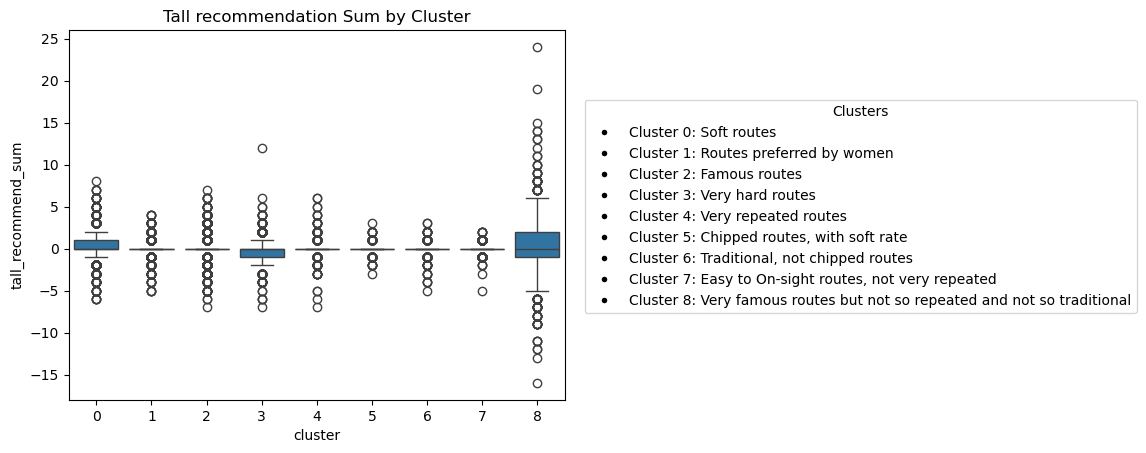

In [9]:
sns.boxplot(x='cluster', y='tall_recommend_sum', data=routes_rated)
plt.title('Tall recommendation Sum by Cluster')
legend_labels = [f'Cluster {num}: {desc}' for num, desc in cluster_descriptions.items()]

legend_handles = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {num}: {desc}',
                         markersize=5, markerfacecolor='black') for num, desc in cluster_descriptions.items()]
plt.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=5, title="Clusters")
plt.show()

- Again not much correlation between type of climb and difficulty based on height.
    - The larger range on cluster 8 could be explained by the not so repeated and not traditional aspects.
    - It could be because they're famous routes that people have attempted them regardless of their own climbing level.


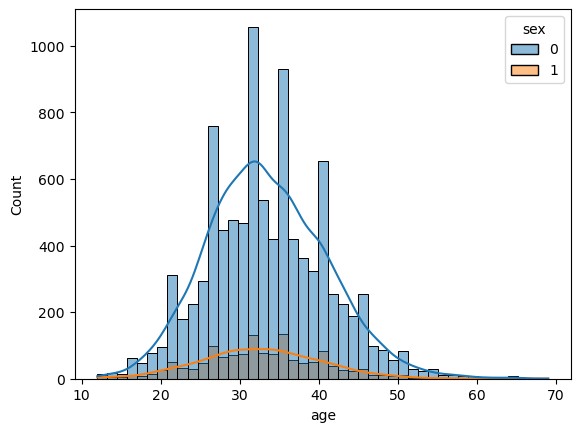

<Axes: xlabel='height', ylabel='Count'>

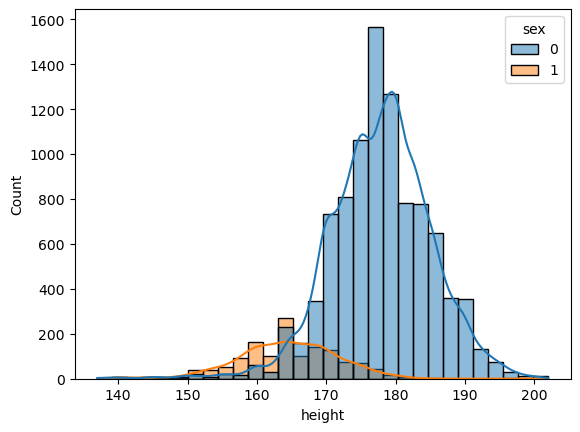

In [10]:
sns.histplot(climbers, x='age', kde=True, bins=45, hue='sex')
plt.show()
sns.histplot(climbers, x='height', kde=True, bins=30, hue='sex')

- From these we can see the age range is normally distributed arround 32 years old, and seems to be consistent for both Men (0) and Women (1).
    - Interestingly there seems to be both very young and some older climbers rating their climbs (we'll take a further look at these)
- We can also see that on average the Men in this dataset are taller, as expected.

In [162]:
climbers['age'].describe()

count    10927.000000
mean        33.333852
std          7.590989
min         12.000000
25%         28.000000
50%         33.000000
75%         38.000000
max         69.000000
Name: age, dtype: float64

In [163]:
climbers[climbers['age'] == 12]

,user_id,country,sex,height,weight,age,years_cl,date_first,date_last,grades_count,grades_first,grades_last,grades_max,grades_mean,year_first,year_last
831,4810,ITA,0,185,68,12.0,20,2003-09-30 22:00:00,2003-09-30 22:00:00,1,49,49,49,49.000000,2003,2003
2051,11076,GBR,0,181,68,12.0,15,2006-07-03 22:00:00,2012-04-05 22:00:00,5,62,55,62,57.200000,2006,2012
8710,47007,other,0,138,40,12.0,5,2013-01-21 23:00:00,2017-08-03 22:00:00,135,31,62,70,51.555556,2013,2017
9551,54131,FRA,1,140,40,12.0,4,2014-12-19 23:00:00,2017-07-28 22:00:00,39,49,57,65,55.615385,2014,2017
9893,57353,FRA,1,165,43,12.0,4,2016-05-13 22:00:00,2017-07-21 22:00:00,18,51,49,57,51.611111,2016,2017
10245,60239,RUS,0,140,40,12.0,3,2015-07-17 22:00:00,2017-08-08 22:00:00,69,35,53,57,42.840580,2015,2017
10374,61108,ITA,0,140,40,12.0,3,2015-10-17 22:00:00,2016-05-27 22:00:00,6,36,40,42,37.833333,2015,2016
10419,61442,POL,1,145,40,12.0,6,2014-06-20 22:00:00,2017-04-01 22:00:00,17,29,51,53,43.058824,2014,2017
10561,63574,ESP,0,150,40,12.0,6,2016-07-21 22:00:00,2017-04-01 22:00:00,22,55,55,59,49.454545,2016,2017
10630,64238,other,1,140,40,12.0,4,2016-04-04 22:00:00,2017-09-03 22:00:00,30,64,59,66,53.033333,2016,2017


- At first glance I can see that there's already some issues with this data.
    - the first entry show's an age of 12 years but 20 years climbed total, they also only have one rated climb.
        - From this information I can assume that 20 years climbed total is likely input by the climber themselves and is how long they've been climbing in their life.
        - The age provided is likely wrong and probably set at some default value when registering
            - This also seems to be the case for other "young" climbers where their age and years climbed don't match up

In [164]:
climbers['country'].value_counts()

country
ESP      1306
USA      1248
other     984
POL       830
ITA       798
SWE       632
FRA       607
DEU       505
BRA       427
NOR       355
AUT       337
ZAF       323
CAN       306
RUS       266
AUS       244
NLD       233
GBR       228
CHE       225
PRT       185
BEL       176
HRV       163
SVN       148
MEX       146
DNK       119
CZE        78
FIN        58
Name: count, dtype: int64

<Axes: xlabel='country', ylabel='count'>

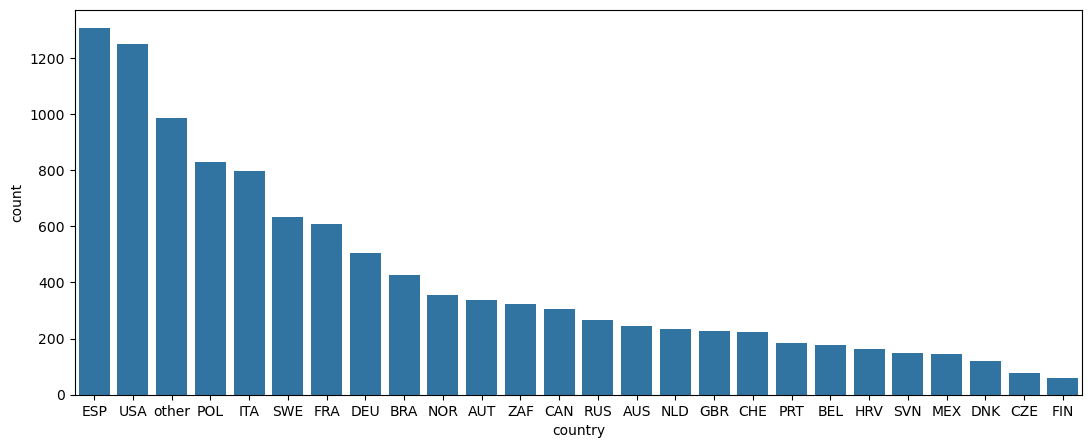

In [165]:
plt.figure(figsize=(13, 5))
sns.countplot(climbers, x='country', order=climbers['country'].value_counts().index)

- A lot of european and american climbers, it makes sense as the site 8a.nu where the dataset came from is run by an italian company.
    - There wasn't any definition for the "other" classification of countries so I can't tell if they come from outside of more western countries.
        - This would be something to check with the dataset provider.

- It would be interesting to see where the best climbers come from in this dataset.

In [12]:
country_groups = climbers.groupby('country')['grades_mean'].mean().reset_index()

country_groups_sorted = country_groups.sort_values(by='grades_mean')

sorted_countries = country_groups_sorted['country'].tolist()

In [62]:
half = len(country_groups_sorted) // 2
first_table = country_groups_sorted.iloc[:half, :]
second_table = country_groups_sorted.iloc[half:, :]

In [13]:
country_values_dict = climbers['country'].value_counts().to_dict()

/tmp/ipykernel_148986/3212644883.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='country', y='grades_mean', data=climbers, order=sorted_countries, palette='viridis')
/tmp/ipykernel_148986/3212644883.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels)


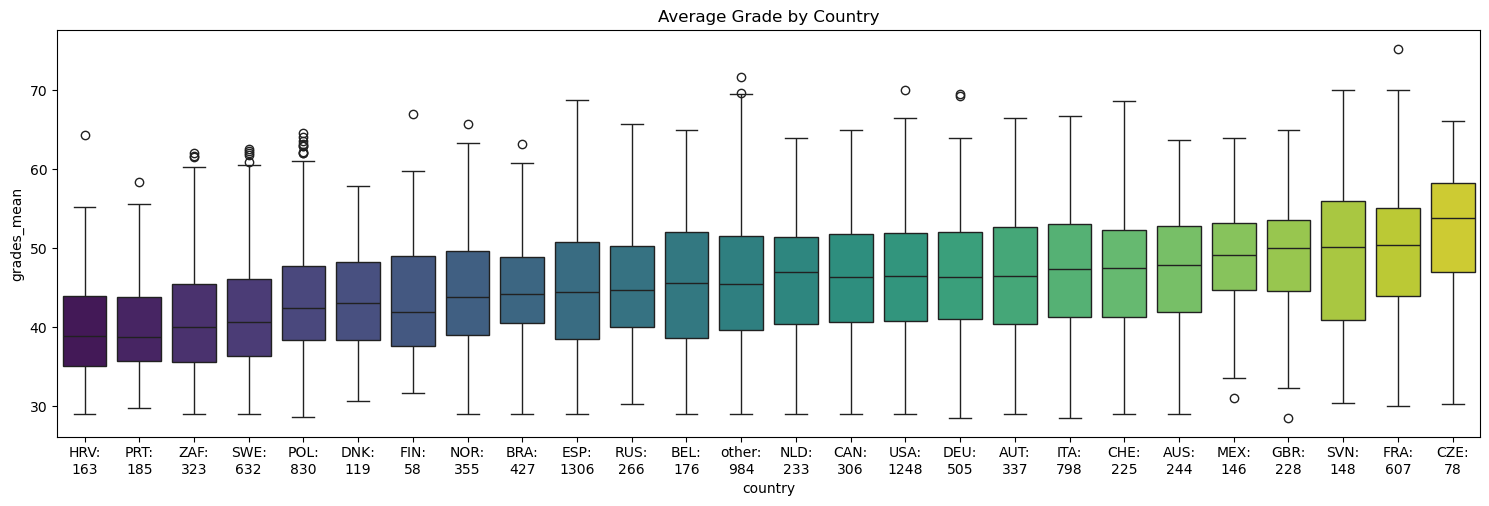

In [14]:
plt.figure(figsize=(15, 5))
ax = sns.boxplot(x='country', y='grades_mean', data=climbers, order=sorted_countries, palette='viridis')
plt.title('Average Grade by Country')
plt.tight_layout()
xticklabels = ax.get_xticklabels()
new_xticklabels = [f"{label.get_text()}:\n{country_values_dict.get(label.get_text())}" for label in xticklabels]
ax.set_xticklabels(new_xticklabels)
plt.show()

In [63]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline;padding-right:50px;"'), raw=True)
# Setting these tables up to give an idea of the grade means for each country along with the french grade conversion
display_side_by_side(first_table, second_table, grade_conversion[(grade_conversion['grade_id'] >= 39) & (grade_conversion['grade_id'] <= 52)])

,country,grades_mean
13,HRV,39.885691
19,PRT,40.070780
24,ZAF,40.914067
22,SWE,41.642236
18,POL,43.195732
8,DNK,43.284274
10,FIN,43.651125
17,NOR,44.477852
3,BRA,44.648069
9,ESP,44.943508


- Median Grades:

    - Countries like France (FRA) and Czech Republic (CZE) have higher median grades compared to others.
    - Countries like Croatia (HRV), Portugal (PRT), and South Africa (ZAF) have lower median grades.

- Variability:

    - Most countries have a similar range of grades, with interquartile ranges showing a similar spread of grades within each country.
    - Czech Republic (CZE), despite having a smaller sample size (78), shows a relatively higher median and IQR compared to others.

- Outliers:

    - Countries like Sweden (SWE), South Africa (ZAF), and Mexico (MEX) show several outliers, indicating some unusually high grades in these countries.
    - France has the largest outlier of the countries here.
        - A lot of the countries with outliers seem to have larger sample sizes indicating that they'll likely have a larger range of skills among climbers.

- Data Spread:

    - Most countries show a similar spread.
    - A lot of the countries have whiskers extending almost the full range of the dataset.
        - Although there can be seen a general upwards trend in the graph amongst the countries there seems to be the full range of skills amongst each one.
        - It's possible that the countries with the lower grades completed just implies there aren't as many higher graded climbs available there.

- Sample Size:

    - The number of entries per country varies, with Spain (ESP) having the highest count of 1306 and Finland (FIN) having the lowest count of 58

- Comparisons:

    - Countries such as France (FRA) and the Czech Republic (CZE) seem to have bouldering grades that are generally higher, indicating potentially more challenging climbs or higher skill levels in these regions.
    - Countries like Croatia (HRV) and Portugal (PRT) have lower median grades, which might indicate easier climbs or lower average skill levels.
    - With a difference of around 1 grade (from 6a+ to 7a+) there isn't too much of a difference in mean grades across the different countries.
        - However, looking at the max ratings it seems that there is a slight upwards trend before we get to Spain where it starts to vary for each country between 60-70
        - From looking around online for stats for the higher grade (>70/8c) range it seems that's in the top 5% of climbers on 8a.nu (https://climbstat.blogspot.com/2018/12/what-is-share-of-climbers-who-can-send.html)
            - It could be said that this 60-70 region may be a plateau of sorts for a lot of climbers